In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

Using TensorFlow backend.


## Multi-Label Text Classification:  Identifying Toxic Online Comments

Here, we will classify Wikipedia comments into one or more categories of so-called *toxic comments*.   Categories of toxic online behavior include toxic, severe_toxic, obscene, threat, insult, and identity_hate.  The dataset can be downloaded from the [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) as a CSV file (i.e., download the file ```train.csv```).  We will load the data using the ```texts_from_csv``` method, which assumes the label_columns are already one-hot-encoded in the spreadsheet. Since *val_filepath* is None, 10% of the data will automatically be used as a validation set.


In [3]:
DATA_PATH = 'data/toxic-comments/train.csv'
NUM_WORDS = 50000
MAXLEN = 150
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_csv(DATA_PATH,
                      'comment_text',
                      label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"],
                      val_filepath=None, # if None, 10% of data will be used for validation
                      max_features=NUM_WORDS, maxlen=MAXLEN,
                      ngram_range=1)

Word Counts: 197516
Nrows: 143613
143613 train sequences
Average train sequence length: 66
x_train shape: (143613,150)
y_train shape: (143613,6)
15958 test sequences
Average test sequence length: 66
x_test shape: (15958,150)
y_test shape: (15958,6)


In [4]:
text.print_text_classifiers()

fasttext: a fastText-like model (http://arxiv.org/pdf/1607.01759.pdf)
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model (http://www.aclweb.org/anthology/P12-2018)
bigru: Bidirectional GRU with pretrained word vectors
bert: Bidirectional Encoder Representations from Transformers (https://arxiv.org/abs/1810.04805)


We weill employ a Bidirectional GRU with pretrained word vectors.  The following code cell loads a BIGRU model and defines a ```Learner``` object based on that model. The file ```crawl-300d-2M.vec ``` contains 2 million word vectors trained by Facebook and will be automatically downloaded for use with this model.

In [5]:
model = text.text_classifier('bigru', (x_train, y_train), preproc=preproc)

learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

Is Multi-Label? True
compiling word ID features...
max_features is 49325
processing pretrained word vectors...
done.


As before, we use our learning rate finder to find a good learning rate. In this case, a learning rate of 0.0007 appears to be good.

simulating training for different learning rates... this may take a few moments...
Epoch 1/1
100352/143613 [===================>..........] - ETA: 10:26 - loss: 0.3649 - acc: 0.7886

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


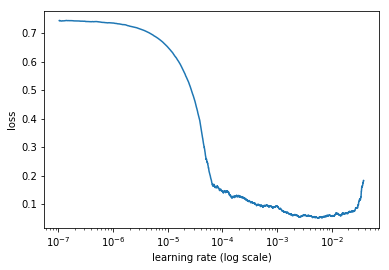

In [7]:
learner.lr_find()
learner.lr_plot()

Finally, we will train our model for 8 epochs using ```autofit``` with a learning rate of 0.001 for two epochs.

In [8]:
# define a custom callback for ROC-AUC
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
RocAuc = RocAucEvaluation(validation_data=(x_test, y_test), interval=1)

In [9]:
# train
learner.autofit(0.001, 2, callbacks=[RocAuc])



begin training using triangular learning rate policy with max lr of 0.001...
Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 2157s 15ms/step - loss: 0.0668 - acc: 0.9787 - val_loss: 0.0410 - val_acc: 0.9843

 ROC-AUC - epoch: 1 - score: 0.986431 

Epoch 2/2
143613/143613 [==============================] - 2142s 15ms/step - loss: 0.0398 - acc: 0.9846 - val_loss: 0.0392 - val_acc: 0.9849

 ROC-AUC - epoch: 2 - score: 0.989871 



Our final ROC-AUC score is **0.9899**.